## Lab 3.2 – Skin Cancer classification: EfficientNet (Pytorch)

This notebook provides an example of using the PyTorch library to build a deep learning model. Objectively, it uses EfficientNet for the skin cancer classification problem.

Dataset consisting of 7 classes: Melanoma(MEL), Melanocytic nevi(NV), Basal cell carcinoma(BCC), Actinic keratoses(AKIEC), Benign keratosis lesions(BKL), Dermatofibroma(DF), and Vascular lesions(VASC).

This example code will consist of:

0. **Setup**
1. **Load Dataset**
2. **Create Model**
3. **train Model**
4. **Inference & Evaluate**

## 0) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [ ]:
!pip install pytorch-lightning
!pip install torchinfo
!pip install -U scikit-learn

--2025-12-29 11:46:02--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip [following]
--2025-12-29 11:46:03--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94841947 (90M) [application/zip]
Saving to: ‘Ham10000_torch.zip’

Ham10000_torch.zip  100%[===================>]  90.45M  46.6MB/s    in 1.9s    

2025-12-29 11:46:05 (46.6 M

In [ ]:
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from random import randint
from typing import NewType

# pytorch libraries
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import Accuracy
import pytorch_lightning as pl

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## 1) Load Dataset

In this step, the dataset is downloaded from GitHub. The directory structure is different from that used in Teachable Machine. Please refer to the following paths:
/content/images/ and /content/GroundTruth.csv

In [ ]:
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
!unzip -q -o 'Ham10000_torch.zip'

In [ ]:
df=pd.read_csv('GroundTruth.csv')
df['image']=df['image'].apply(lambda x: x+ '.jpg')
df = df.drop(columns=["Unnamed: 0"])

print (df.head())

              image  MEL  NV  BCC  AKIEC  BKL  DF  VASC
0  ISIC_0024310.jpg    1   0    0      0    0   0     0
1  ISIC_0024306.jpg    0   1    0      0    0   0     0
2  ISIC_0024331.jpg    0   0    1      0    0   0     0
3  ISIC_0024329.jpg    0   0    0      1    0   0     0
4  ISIC_0024312.jpg    0   0    0      0    1   0     0


In [ ]:
# Set dataset format
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis like lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

labels = list(df.columns[1:])
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=lesion_type_dict[labels[index]]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
df['label_idx'] = pd.Categorical(df['label']).codes
print(df)

                image                          label  label_idx
0    ISIC_0024310.jpg                       Melanoma          5
1    ISIC_0024306.jpg               Melanocytic nevi          4
2    ISIC_0024331.jpg           Basal cell carcinoma          1
3    ISIC_0024329.jpg              Actinic keratoses          0
4    ISIC_0024312.jpg  Benign keratosis like lesions          2
..                ...                            ...        ...
345  ISIC_0025285.jpg           Basal cell carcinoma          1
346  ISIC_0025712.jpg              Actinic keratoses          0
347  ISIC_0024760.jpg  Benign keratosis like lesions          2
348  ISIC_0028926.jpg                 Dermatofibroma          3
349  ISIC_0027672.jpg               Vascular lesions          6

[350 rows x 3 columns]


In [ ]:
# Split dataset
train_df, val_df, test_df = df[:210], df[210:280], df[280:350]
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('Data Len Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

Data Len Train: 210 Val: 70 Test: 70


In [ ]:
# Set transform (preprocessing)
train_transform = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

val_transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

In [ ]:
# Dataset object
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(os.path.join('images', self.df['image'][index]))
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
# Create Dataloader (dataset object+transform)
# Define the training,val,test sets using the tables and using our defined transitions
BATCH_SIZE = 10
NUM_WORKERS = 2

train_set = HAM10000(train_df, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_set = HAM10000(val_df, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

test_set = HAM10000(test_df, transform=val_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print('Data Len Train:', len(train_set), 'Val:', len(val_set), 'Test:', len(test_set))

Data Len Train: 210 Val: 70 Test: 70


## 2) Create Model

In [ ]:
# Create model & set loss function
class LitEfficientNetV2(pl.LightningModule):
    def __init__(self, num_classes=7, learning_rate=1e-3):
        super().__init__()
        # Load EfficientNetV2 model from torchvision
        self.model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
        # Replace the classifier with a custom layer for our task
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # Collect epoch metrics

        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = LitEfficientNetV2().to(device)

## 3) Train Model

In [ ]:
# Train model
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",       # Monitor validation accuracy
    mode="max",              # Save the model with the highest accuracy
    save_top_k=1,            # Save only the best model
    filename="efficientnetv2-best-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True             # Print messages when saving
)

trainer = pl.Trainer(max_epochs=50, callbacks=[checkpoint_callback])
trainer.fit(net, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ EfficientNet       │ 20.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ accuracy  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 20.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.2 M                                                                                               
Total estimated model params size (MB): 80                                                                         
Modules in train mode: 716                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches 
(21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 21: 'val_acc' reached 0.32857 (best 0.32857), saving model to '/content/lightning_logs/version_5/checkpoints/efficientnetv2-best-epoch=00-val_acc=0.3286.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 42: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 63: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 84: 'val_acc' reached 0.44286 (best 0.44286), saving model to '/content/lightning_logs/version_5/checkpoints/efficientnetv2-best-epoch=03-val_acc=0.4429.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 105: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 126: 'val_acc' reached 0.47143 (best 0.47143), saving model to '/content/lightning_logs/version_5/checkpoints/efficientnetv2-best-epoch=05-val_acc=0.4714.ckpt' as top 1
INFO:pytorch_ligh

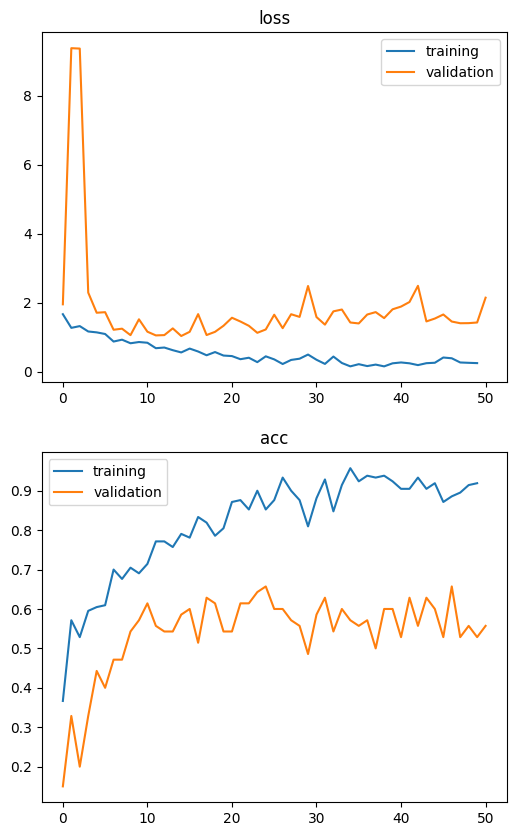

In [ ]:
# Plot loss & accuracy
fig, axs = plt.subplots(2, figsize= (6,10))
# loss
axs[0].plot([entry['train_loss'] for entry in net.train_metrics], label = 'training')
axs[0].plot([entry['val_loss'] for entry in net.val_metrics], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot([entry['train_acc'] for entry in net.train_metrics], label = 'training')
axs[1].plot([entry['val_acc'] for entry in net.val_metrics], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()

## 4) Evaluation & Inference

In [ ]:
# Use the best model for inference
print(f"Best model saved at: {checkpoint_callback.best_model_path}")

best_model_path = checkpoint_callback.best_model_path
best_model = LitEfficientNetV2.load_from_checkpoint(best_model_path).to(device)

best_model.eval()
best_model.freeze()

Best model saved at: /content/lightning_logs/version_5/checkpoints/efficientnetv2-best-epoch=23-val_acc=0.6571.ckpt


In [ ]:
# Evaluate in test dataset
criterion = nn.CrossEntropyLoss()
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(test_loader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )


    class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

    report = classification_report(y_labels, y_predict, target_names=class_names, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=class_names)

testing ...


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]

testing loss: 1.14
              precision    recall  f1-score   support

         MEL     0.4444    0.8000    0.5714        10
          NV     0.7000    0.7000    0.7000        10
         BCC     0.6250    0.5000    0.5556        10
       AKIEC     0.5385    0.7000    0.6087        10
         BKL     0.7500    0.6000    0.6667        10
          DF     1.0000    0.3000    0.4615        10
        VASC     1.0000    1.0000    1.0000        10

    accuracy                         0.6571        70
   macro avg     0.7226    0.6571    0.6520        70
weighted avg     0.7226    0.6571    0.6520        70



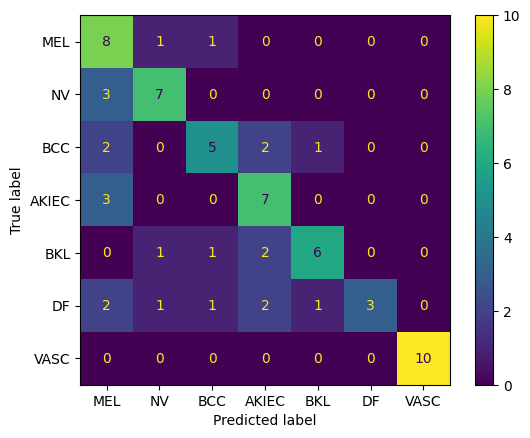

In [ ]:
disp.plot()
plt.show()

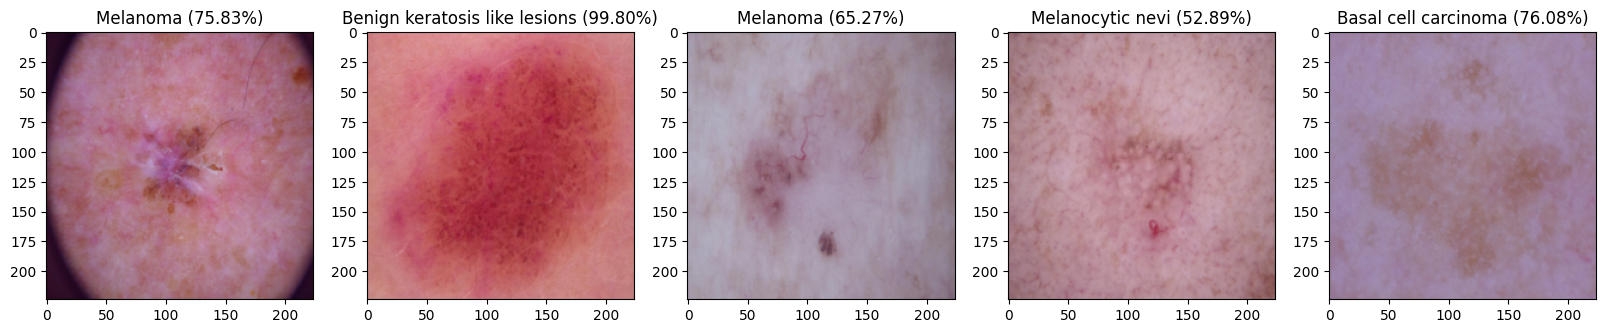

In [ ]:
# Example case
plt.figure(figsize=(20,5))
dataiter = iter(test_loader)
inputs, labels = next(dataiter)
with torch.no_grad():

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels = list(labels.cpu().numpy())
        y_predict = list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())

# We selected a sample from the first five images for visualization
for i in range(5):
    plt.subplot(1,5,i+1)
    img = inputs[i]
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    most_prob = np.argmax(y_probs[i])
    label = df['label'][most_prob]
    prob = y_probs[i][most_prob]
    plt.title(f"{label} ({prob*100:.2f}%)")